In [1]:
import gensim
import pyLDAvis
import pickle
import zipfile
import pyLDAvis
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyLDAvis import gensim as gs
from ast import literal_eval
from os.path import exists

Load the model, corpus, dictionary and data

In [2]:
model = gensim.models.LdaModel.load('models/model_rs1024k36')
with open('models/corpus.pkl', 'rb') as f:
    corpus = pickle.load(f)
dictionary = gensim.corpora.dictionary.Dictionary.load('models/dictionary')

if not exists('data/data_for_interpretation.csv'):
    print('Unzipping data.zip')
    with zipfile.ZipFile('data.zip', 'r') as zip_ref:
        zip_ref.extractall('data')

df = pd.read_csv('data/data_for_interpretation.csv', usecols=["scopusId", "title", "keywords", "abstract", "data", "data_preprocessed", "modularity_class"])  
df['data_preprocessed'] = df['data_preprocessed'].apply(literal_eval)

Show the topics

In [3]:
topics = model.show_topics(formatted=False, num_topics=36)

Generate and show a pyLDAvis visualisation for easy exploration

In [4]:
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary, sort_topics=False)
pyLDAvis.save_html(vis, 'visualisation.html')
pyLDAvis.display(vis)

Loop through all the documents to infer document-topics distribition

In [5]:
def inf_dist(text):
          
    bow = model.id2word.doc2bow(text)
    topics = model.get_document_topics(bow, per_word_topics=False)

    dic_topics = {}
    for t in topics:
        dic_topics[t[0]] = float(t[1])

    return dic_topics
      
df["document_topic_distribution"] = df["data_preprocessed"].map(inf_dist)

Loop trought all documents and classify with a main topic

In [6]:
def main_topic(text):
    
    highest_key = -1
    highest_value = -1
    
    for k in text.keys():
        if text[k] > highest_value:
            highest_key = k
            highest_value = text[k]
    
    return highest_key

df["main_topic"] = df["document_topic_distribution"].map(main_topic)

Add a column with the proportion of the main topic

In [7]:
def main_topic_value(text):
    
    highest_key = -1
    highest_value = -1
    
    for k in text.keys():
        if text[k] > highest_value:
            highest_key = k
            highest_value = text[k]
    
    return highest_value

df["main_topic_value"] = df["document_topic_distribution"].map(main_topic_value)
df

scopusId  modularity_class  \
0      85076020241              1234   
1      85076100848               177   
2      85075971302               273   
3      85075054747               273   
4      85070515257               637   
...            ...               ...   
79428      1161568               177   
79429  58149445149              1255   
79430  58149419835              1255   
79431      1531225               865   
79432     11506578               177   

                                                   title  \
0      Reversible Image Steganography Using Dual-Laye...   
1      Why do people share their travel experiences o...   
2      Privacy-preserving in association rule mining ...   
3      Mathematically optimized, recursive prepartiti...   
4      Recording brain activity can function as an im...   
...                                                  ...   
79428                          Privacy-a useful concept?   
79429  Schmidt Is Wrong on Privileged Communication: ...   
79430  Some legal considerations for counseling and c...   
79431                        Speech Privacy in Buildings   
79432  Studies in adjustment to visible injuries: eva...   

                                                keywords  \
0      ['Embedding efficiency', 'Reversible informati...   
1      ['Sharing travel experiences', 'Social influen...   
2      ['Artificial bee colony', 'Association rule hi...   
3      ['Data privacy', 'k-anonymity', 'Large-scale d...   
4      ['invasive technology', 'privacy concerns', 'R...   
...                                                  ...   
79428                                                NaN   
79429  ['certification', 'clinical psychologists', 'c...   
79430  ['CLINICAL PSYCHOLOGY, & LEGAL CONSIDERATIONS'...   
79431                                                NaN   
79432  ['ADJUSTMENT, TO VISIBLE INJURIES', 'BEHAVIOR ...   

                                                abstract  \
0      Recently, reversible information hiding (RIH) ...   
1      Tourism practices and destination decisions ar...   
2       Although there are some evolutionary-based AR...   
3       A widely known technique to solve the problem...   
4      People often behave differently when they know...   
...                                                  ...   
79428  Psychologically, privacy is a self-related sub...   
79429  Comments on the original article "Some legal c...   
79430  Limited comments on legal issues in profession...   
79431  Obtaining adequate speech privacy in modern bu...   
79432  Interviews with 100 visibly injured servicemen...   

                                                    data  \
0      Recently, reversible information hiding (RIH) ...   
1      Tourism practices and destination decisions ar...   
2       Although there are some evolutionary-based AR...   
3       A widely known technique to solve the problem...   
4      People often behave differently when they know...   
...                                                  ...   
79428  Psychologically, privacy is a self-related sub...   
79429  Comments on the original article "Some legal c...   
79430  Limited comments on legal issues in profession...   
79431  Obtaining adequate speech privacy in modern bu...   
79432  Interviews with 100 visibly injured servicemen...   

                                       data_preprocessed  \
0      [recently, reversible, information, hiding, ri...   
1      [tourism, practice, destination, decision, aff...   
2      [although, evolutionary, based, arh, algorithm...   
3      [widely, known, technique, solve, problem, pro...   
4      [people, often, behave, differently, know, wat...   
...                                                  ...   
79428  [psychologically, privacy, self, related, subj...   
79429  [comment, original, article, legal, considerat...   
79430  [limited, comment, legal, issue, professional,...   
79431  [obtaining, adequate, speech, privacy,

Make a dataframe with individual columns for each topic and community (modularity class) for easy correlation computation

In [8]:
topic_dicts = [{} for topic in range(36)]

# make dict of values for eacht topic
for i, topic_dict in enumerate(topic_dicts):
    
    for j, topic_distribution in enumerate(df['document_topic_distribution']):
        try:
            value = topic_distribution[i]
        except:
            value = 0
        
        topic_dicts[i][j] = value 

topic_per_paper = pd.DataFrame(topic_dicts).transpose()
topic_per_paper.columns = ['Topic ' + str(i) for i in range(36)]
topic_per_paper

Topic 0  Topic 1   Topic 2  Topic 3  Topic 4   Topic 5   Topic 6  \
0      0.000000      0.0  0.199722      0.0      0.0  0.639508  0.000000   
1      0.404715      0.0  0.000000      0.0      0.0  0.000000  0.000000   
2      0.000000      0.0  0.000000      0.0      0.0  0.131757  0.562605   
3      0.000000      0.0  0.000000      0.0      0.0  0.000000  0.565838   
4      0.000000      0.0  0.000000      0.0      0.0  0.000000  0.000000   
...         ...      ...       ...      ...      ...       ...       ...   
79428  0.000000      0.0  0.000000      0.0      0.0  0.000000  0.000000   
79429  0.000000      0.0  0.000000      0.0      0.0  0.000000  0.000000   
79430  0.000000      0.0  0.000000      0.0      0.0  0.000000  0.000000   
79431  0.000000      0.0  0.000000      0.0      0.0  0.000000  0.000000   
79432  0.000000      0.0  0.000000      0.0      0.0  0.000000  0.000000   

        Topic 7  Topic 8  Topic 9  ...  Topic 26  Topic 27  Topic 28  \
0      0.000000      0.0  0.00000  ...  0.000000  0.000000  0.000000   
1      0.000000      0.0  0.00000  ...  0.000000  0.000000  0.028784   
2      0.000000      0.0  0.00000  ...  0.000000  0.000000  0.000000   
3      0.000000      0.0  0.00000  ...  0.000000  0.000000  0.000000   
4      0.000000      0.0  0.03993  ...  0.000000  0.000000  0.000000   
...         ...      ...      ...  ...       ...       ...       ...   
79428  0.568470      0.0  0.00000  ...  0.000000  0.000000  0.000000   
79429  0.722048      0.0  0.00000  ...  0.000000  0.000000  0.000000   
79430  0.655538      0.0  0.00000  ...  0.000000  0.173165  0.000000   
79431  0.124660      0.0  0.00000  ...  0.217932  0.000000  0.000000   
79432  0.356293      0.0  0.00000  ...  0.000000  0.000000  0.000000   

       Topic 29  Topic 30  Topic 31  Topic 32  Topic 33  Topic 34  Topic 35  
0      0.000000  0.055416  0.000000  0.000000       0.0       0.0       0.0  
1      0.208264  0.000000  0.000000  0.000000       0.0       0.0       0.0  
2      0.000000  0.000000  0.000000  0.000000       0.0       0.0       0.0  
3      0.000000  0.000000  0.140027  0.023907       0.0       0.0       0.0  
4      0.000000  0.000000  0.000000  0.000000       0.0       0.0       0.0  
...         ...       ...       ...       ...       ...       ...       ...  
79428  0.000000  0.000000  0.000000  0.000000       0.0       0.0       0.0  
79429  0.000000  0.209420  0.053198  0.000000       0.0       0.0       0.0  
79430  0.000000  0.150021  0.000000  0.000000       0.0       0.0       0.0  
79431  0.000000  0.000000  0.103784  0.280051       0.0       0.0       0.0  
79432  0.000000  0.040103  0.000000  0.441119       0.0       0.0       0.0  

[79433 rows x 36 columns]

Manually specify topic names

In [11]:
topic_names = ['consumer privacy', 'smartphones', 'quantum encryption', 'networking', 'smart grid', 'image processing', 'data mining', 'legal', 'security operations', 'big data', 'internet of things', 'multi-party computing', 'privacy-preserving algorithms', 'social media', 'digital services', 'RFID', 'biometrics', 'healthcare (patient privacy)', 'recommender systems (+healthcare)', 'physical monitoring', 'location data', 'access control', 'blockchain', 'cloud computing', 'encryption', 'data privacy', 'systems design', 'ethics', 'vehicular ad hoc networks', 'social networks', 'patient data', 'statistics', 'empirical studies', 'encryption schemes', 'web applications', 'cloud storage']

Show a heatmap of topic occurence correlation

In [12]:
topic_correlations = topic_per_paper.corr()

f, ax = plt.subplots(figsize=(22, 16), dpi = 480)
mask = np.triu(np.ones_like(topic_correlations, dtype=bool))
triangle = sns.heatmap(topic_correlations, cmap=sns.color_palette("vlag_r", as_cmap=True), center = 0, annot=True, mask = mask, fmt='.2f', xticklabels=topic_names, yticklabels=topic_names)
triangle.get_figure().savefig('triangle.png', bbox_inches='tight')
triangle

<AxesSubplot:>

Count communities and sort by occurence to match with the right labels

In [13]:
communities = {}

for module in df['modularity_class']:
    
    if module in communities.keys():
        communities[module] += 1
    else:
        communities[module] = 1
        
sorted_values = sorted(communities.values(), reverse = True) 

sorted_communities = {}

for i, value in enumerate(sorted_values):
     for k in communities.keys():
        if communities[k] == value:
            sorted_communities[k] = communities[k]
            
names = ['idividual privacy and law', 'cloud computing', 'e-health and medical data', 'data mining', 'genetic data', 'location data', 'anonymity metrics', 'internet of things', 'differential privacy', 'electronic voting', 'networking', 'cybersecurity', 'mobile devices and apps', 'system architecture and design', 'vehicular ad hoc networks', 'RFID', 'social media', 'physical privacy (various)', 'biometrics', 'smart grid'] 
keys = [key for key in sorted_communities.keys()]

communities = {}

for i in range(len(names)):
    communities[str(keys[i])] = (names[i], sorted_communities[keys[i]])

communities

{'177': ('idividual privacy and law', 11768),
 '695': ('cloud computing', 8914),
 '1234': ('e-health and medical data', 5636),
 '273': ('data mining', 5496),
 '279': ('genetic data', 4596),
 '757': ('location data', 4541),
 '58': ('anonymity metrics', 3909),
 '637': ('internet of things', 3706),
 '282': ('differential privacy', 3383),
 '413': ('electronic voting', 3249),
 '277': ('networking', 2969),
 '224': ('cybersecurity', 2953),
 '313': ('mobile devices and apps', 2312),
 '813': ('system architecture and design', 2283),
 '708': ('vehicular ad hoc networks', 1982),
 '1208': ('RFID', 1837),
 '274': ('social media', 1734),
 '458': ('physical privacy (various)', 1703),
 '865': ('biometrics', 1672),
 '880': ('smart grid', 1265)}

In [14]:
community_names = [value[0].lower() for value in communities.values()]

Compute the averate presence of each topic for each community (modularity class)

In [15]:
topic_per_paper_with_community = pd.concat([df['modularity_class'], topic_per_paper], axis=1)
topical_distr_per_community = {}

for key in communities:        
    
    entries = topic_per_paper_with_community[topic_per_paper_with_community['modularity_class'] == int(key)]        
                
    averages = {}
    
    for topic in ['Topic ' + str(i) for i in range(36)]:
        averages[topic] = entries[topic].mean()

    topical_distr_per_community['Modularity class ' + str(key)] = averages
    
topical_distr_per_community_df = pd.DataFrame(topical_distr_per_community).transpose()

Create a heatmap to visualise average occurance of a topic within each community

<AxesSubplot:>

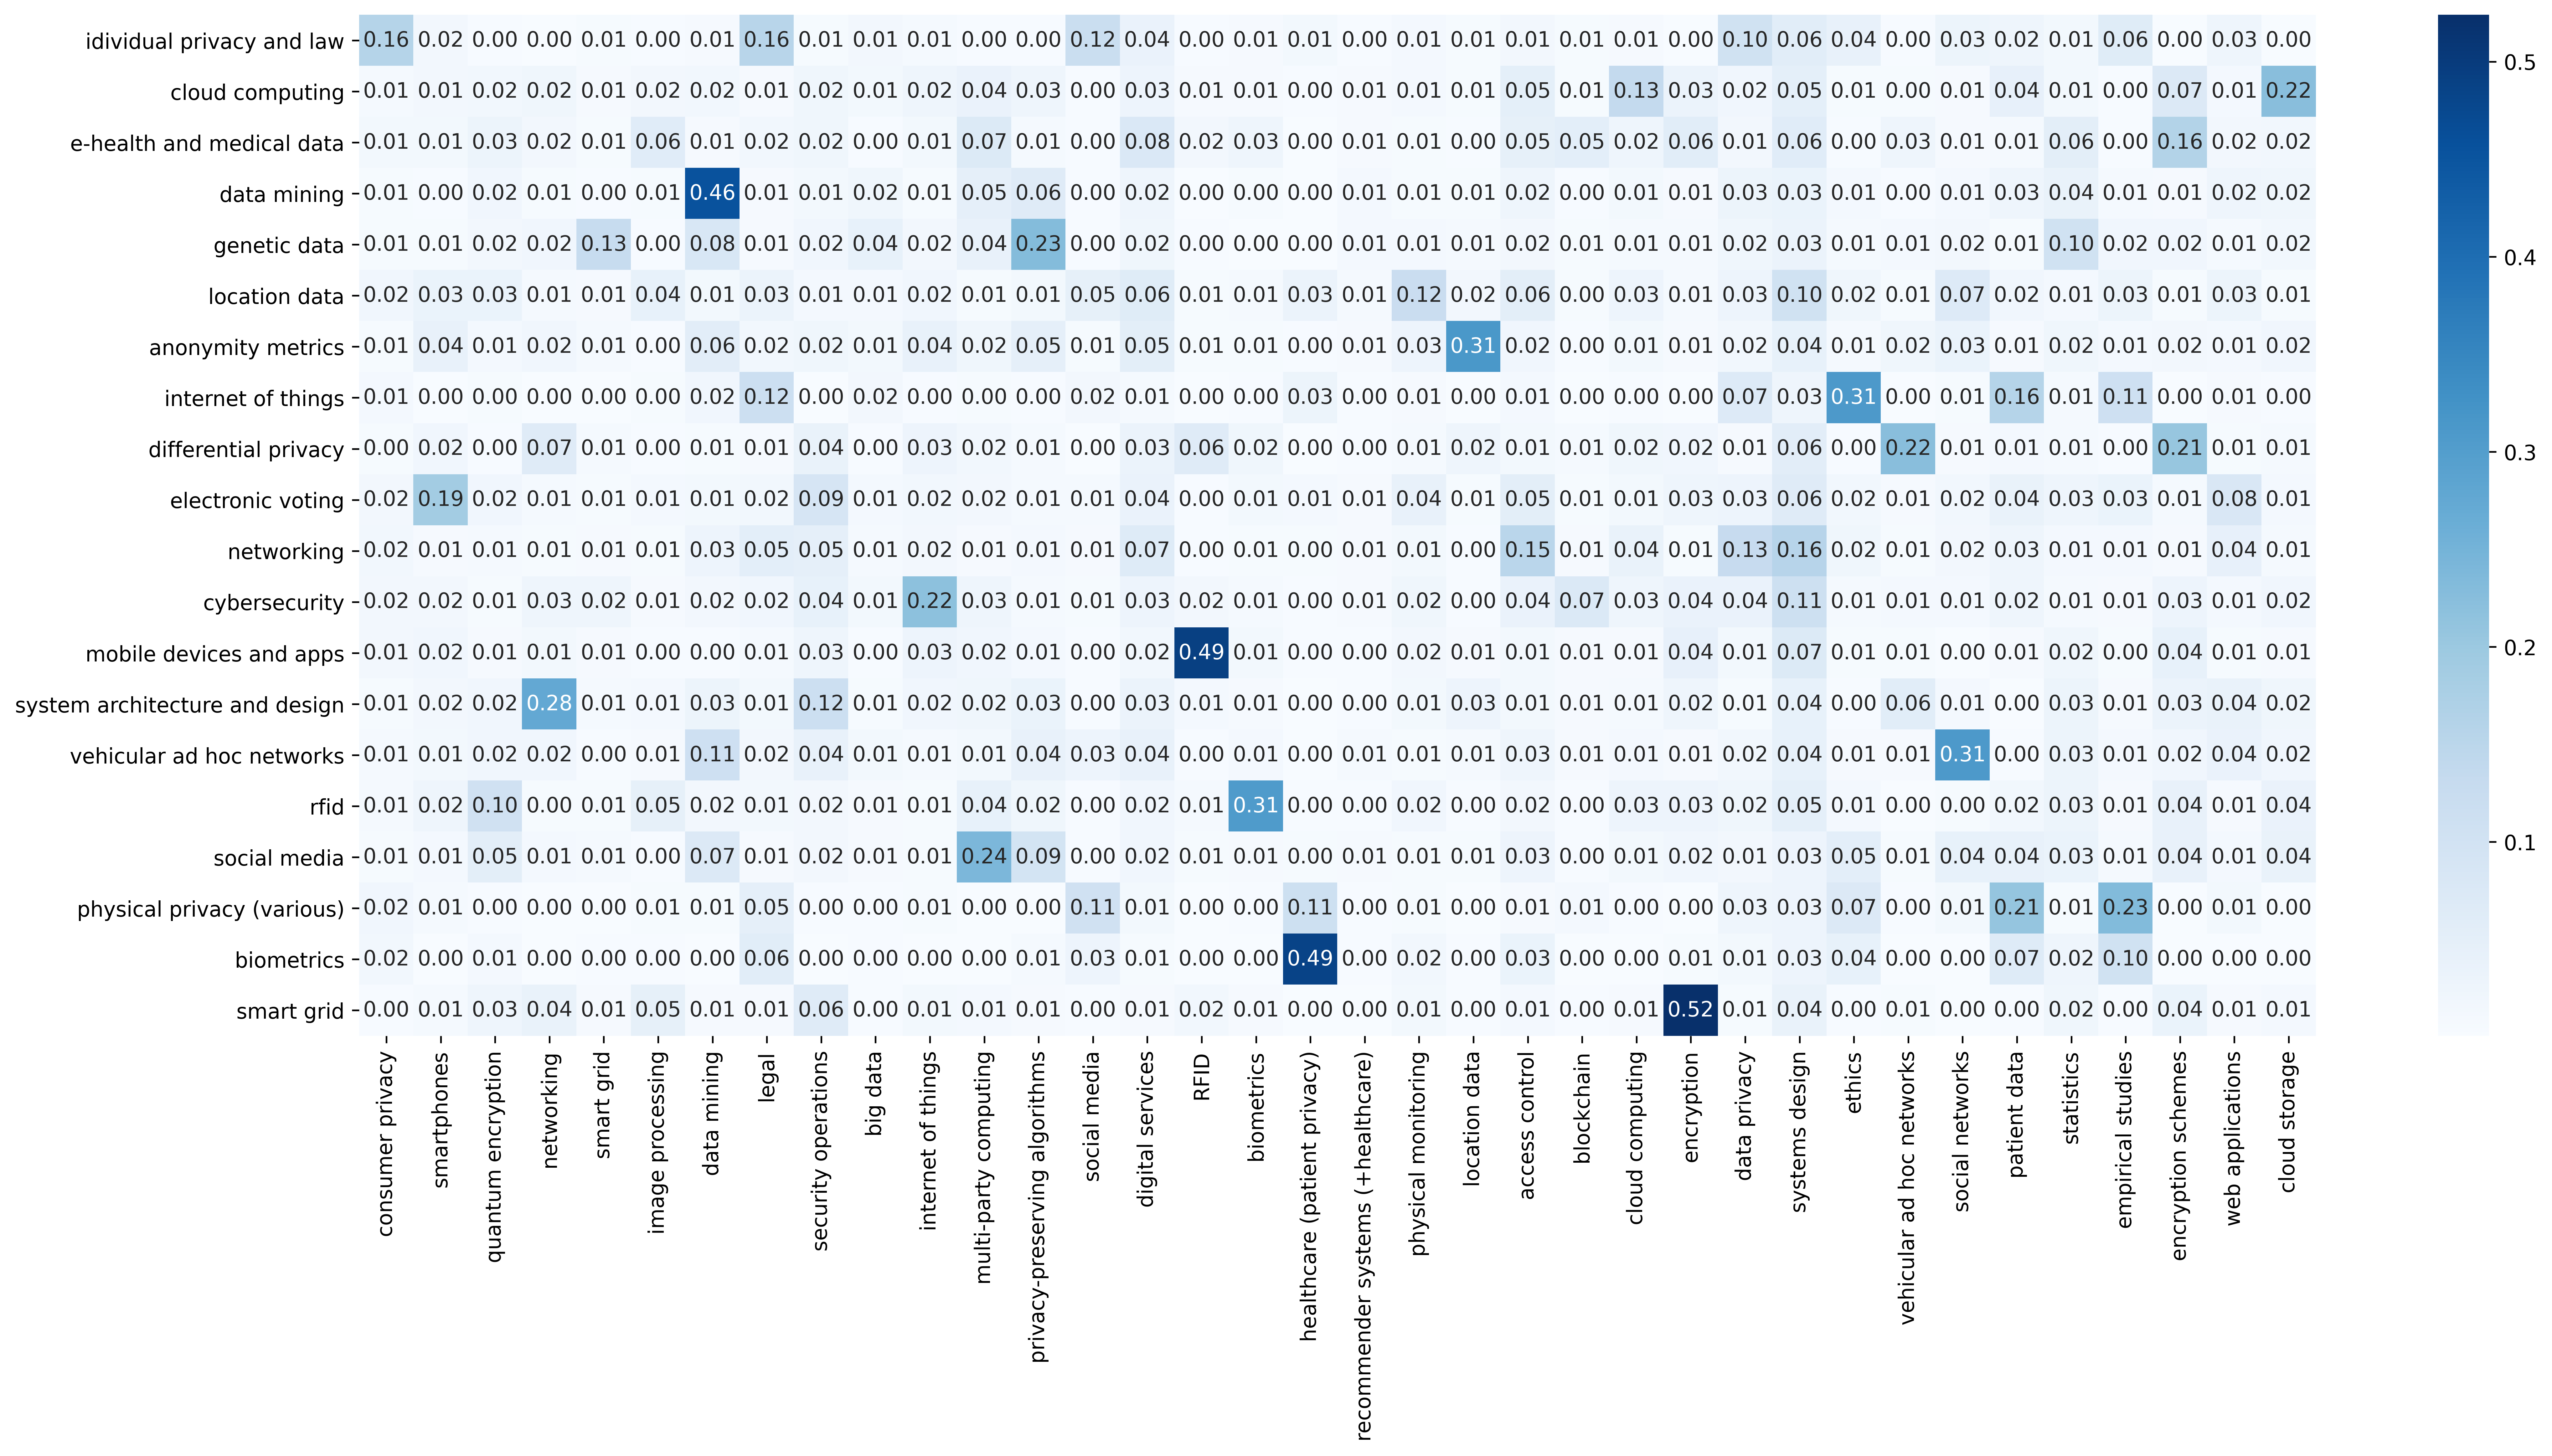

In [16]:
f, ax = plt.subplots(figsize=(21, 9), dpi = 480)
square = sns.heatmap(topical_distr_per_community_df, cmap=sns.color_palette("Blues", as_cmap=True), annot=True, fmt='.2f', xticklabels=topic_names, yticklabels=community_names)
square.get_figure().savefig('square.png', bbox_inches='tight')
square